<a href="https://colab.research.google.com/github/thieuhy/AgenticAI_Business_SJSU/blob/Agentic-AI-in-Customer-Service-and-Sales/Group_8_Agentic_AI_in_Customer_Service_and_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product QnA Agent Chatbot


In [ ]:
# --- install dependencies (run once per session)
!pip -q install langchain langchain_openai openai

# --- imports
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import os
from getpass import getpass

# --- ask each user to enter their own key securely
if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

# --- setup the model + embeddings
model = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

print("✅ LangChain + OpenAI setup complete.")

✅ LangChain + OpenAI setup complete.


In [ ]:
import pandas as pd
from langchain_core.tools import tool

#Load the headphone product pricing CSV into a Pandas dataframe.
product_pricing_df = pd.read_csv("/content/Headphone Pricing - Sheet1.csv")
# Clean up column names by stripping whitespace
product_pricing_df.columns = product_pricing_df.columns.str.strip()
print(product_pricing_df)

@tool
def get_headphone_price(headphone_name:str) -> int :
    """
    This function returns the price of a headphone, given its name as input.
    It performs a substring match between the input name and the headphone name.
    If a match is found, it returns the pricxe of the headphone.
    If there is NO match found, it returns -1
    """

    #Filter Dataframe for matching names
    match_records_df = product_pricing_df[
                        product_pricing_df["Name"].str.contains(
                                                "^" + headphone_name, case=False)
                        ]
    #Check if a record was found, if not return -1
    if len(match_records_df) == 0 :
        return -1
    else:
        return match_records_df["Price"].iloc[0]

#Test the tool. Before running the test, comment the @tool annotation
#print(get_headphone_price("Sony WH-1000XM5"))
#print(get_headphone_price("Bose QuietComfort"))
#print(get_headphone_price("random test"))  # should return -1

                      Name  Price  Shipping Size
0          Sony WH-1000XM5    399              2
1  Bose QuietComfort Ultra    429              7
2        Apple AirPods Max    549              7
3    Sennheiser Momentum 4    379             14
4          JBL Tour One M2    279              2


In [ ]:
# --- Install (only once per runtime) ---
!pip install -q langchain langchain-openai langchain-chroma langchain-community langchain-text-splitters pypdf langgraph

# --- Imports ---
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import Tool

# === 1. Load, chunk, and index the contents of your headphone PDF ===
# Replace with your actual headphone feature document
loader = PyPDFLoader("/content/Product Description.pdf")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=256)
splits = text_splitter.split_documents(docs)

# === 2. Create vector store with Chroma ===
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

prod_feature_store = Chroma.from_documents(
    documents=splits,
    embedding=embeddings        # (use embedding_function=embeddings if you import from langchain_community.vectorstores)
)

retriever = prod_feature_store.as_retriever(search_kwargs={"k": 1})

# === 3. Create a retriever Tool (no version conflict) ===
def _search_headphone_features(query: str) -> str:
    """Search the indexed headphone features PDF."""
    docs = retriever.invoke(query)
    if not docs:
        return "No matching headphone information found."
    return docs[0].page_content

get_product_features = Tool(
    name="Get_Product_Features",
    description=(
        "This store contains details about headphones. "
        "It lists available models and their features including "
        "wireless connectivity, noise cancellation, battery life, design, and advantages."
    ),
    func=_search_headphone_features,
)

# === 4. Test the tool ===
# Uncomment to test
# print(get_product_features.run("Tell me about the Sony WH-1000XM5"))

In [ ]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

#Create a System prompt to provide a persona to the chatbot
system_prompt = SystemMessage("""
    You are professional chatbot that answers questions about headphone sold by your company.
    To answer questions about headphone, you will ONLY use the available tools and NOT your own memory.
    You will handle small talk and greetings by producing professional responses.
    """
)

#Create a list of tools available
tools = [get_headphone_price, get_product_features]

#Create memory across questions in a conversation (conversation memory)
checkpointer=MemorySaver()

#Create a Product QnA Agent. This is actual a graph in langGraph
product_QnA_agent=create_react_agent(
                                model=model, #LLM to use
                                tools=tools, #List of tools to use
                                # The system prompt might be handled differently and not as a direct argument here
                                debug=False, #Debugging turned on if needed
                                checkpointer=checkpointer #For conversation memory
)

/tmp/ipython-input-2726189538.py:20: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  product_QnA_agent=create_react_agent(


In [ ]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
import uuid # import uuid here

#Create a System prompt to provide a persona to the chatbot
system_prompt = SystemMessage("""
    You are professional chatbot that answers questions about headphone sold by your company.
    To answer questions about headphone, you will ONLY use the available tools and NOT your own memory.
    You will handle small talk and greetings by producing professional responses.
    """
)

#Create a list of tools available
tools = [get_headphone_price, get_product_features]

#Create memory across questions in a conversation (conversation memory)
checkpointer=MemorySaver()

#Create a Product QnA Agent. This is actual a graph in langGraph
product_QnA_agent=create_react_agent(
                                model=model, #LLM to use
                                tools=tools, #List of tools to use
                                # The system prompt might be handled differently and not as a direct argument here
                                debug=False, #Debugging turned on if needed
                                checkpointer=checkpointer #For conversation memory
)

#Setup chatbot
#To maintain memory, each request should be in the context of a thread.
#Each user conversation will use a separate thread ID
config = {"configurable": {"thread_id": uuid.uuid4()}}

#Test the agent with an input
inputs = {"messages":[
                HumanMessage("What are the features and pricing for Sony WH-1000XM5?")
            ]}

#Use streaming to print responses as the agent  does the work.
#This is an alternate way to stream agent responses without waiting for the agent to finish
for stream in product_QnA_agent.stream(inputs, config, stream_mode="values"):
    message=stream["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

/tmp/ipython-input-4050622806.py:21: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  product_QnA_agent=create_react_agent(


================================ Human Message =================================

What are the features and pricing for Sony WH-1000XM5?
================================== Ai Message ==================================
Tool Calls:
  Get_Product_Features (call_bUPeKCoTRXudK2iMO2UNRzYP)
 Call ID: call_bUPeKCoTRXudK2iMO2UNRzYP
  Args:
    __arg1: Sony WH-1000XM5
  get_headphone_price (call_I9vcyHSIQWJJgSwTtBQmsKkz)
 Call ID: call_I9vcyHSIQWJJgSwTtBQmsKkz
  Args:
    headphone_name: Sony WH-1000XM5
================================= Tool Message =================================
Name: get_headphone_price

399
================================== Ai Message ==================================

### Features of Sony WH-1000XM5:
- **Noise Cancellation**: Industry-leading noise cancellation with dual processors and advanced microphones.
- **Design**: Lightweight design with plush earcups, making it comfortable for long listening sessions.
- **Battery Life**: Offers a 30-hour battery life with fast c

In [ ]:
import uuid
from langchain_core.messages import HumanMessage # Import HumanMessage here

#Send a sequence of messages to chatbot and get its response
#This simulates the conversation between the user and the Agentic chatbot
user_inputs = [
    "Hello",
    "I am looking to buy a headphone",
    "Give me a list of available headphone names",
    "Tell me about the features of Sony WH-1000XM5",
    "How much does it cost?",
    "Give me similar information about Bose QuietComfort Ultra",
    "What info do you have on Apple AirPods Max?",
    "Thanks for the help"
]

#Create a new thread
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = product_QnA_agent.invoke(user_message,config=config)
    #Print the response
    print(f"AGENT : {ai_response['messages'][-1].content}")

----------------------------------------
USER : Hello
AGENT : Hello! How can I assist you today?
----------------------------------------
USER : I am looking to buy a headphone
AGENT : Great! What specific features or requirements are you looking for in a headphone? For example, do you prefer wireless or wired, noise cancellation, battery life, or any particular brand?
----------------------------------------
USER : Give me a list of available headphone names
AGENT : I currently don't have direct access to a list of available headphone names. However, I can help you find specific models or features if you have something in mind. Alternatively, I can provide information on popular headphone brands and models. Would you like me to do that?
----------------------------------------
USER : Tell me about the features of Sony WH-1000XM5
AGENT : The Sony WH-1000XM5 headphones offer the following features:

- **Industry-Leading Noise Cancellation**: Equipped with dual processors and advanced mi

In [ ]:
#conversation memory by user
def execute_prompt(user, config, prompt):
    inputs = {"messages":[("user",prompt)]}
    ai_response = product_QnA_agent.invoke(inputs,config=config)
    print(f"\n{user}: {ai_response['messages'][-1].content}")

#Create different session threads for 2 users
config_1 = {"configurable": {"thread_id": str(uuid.uuid4())}}
config_2 = {"configurable": {"thread_id": str(uuid.uuid4())}}

#Test both threads
execute_prompt("USER 1", config_1, "Tell me about the features of Sennheiser Momentum 4")
execute_prompt("USER 2", config_2, "Tell me about the features of JBL Tour One M2")
execute_prompt("USER 1", config_1, "What is its price?")
execute_prompt("USER 2", config_2, "What is its price?")


USER 1: The Sennheiser Momentum 4 Wireless headphones offer a range of impressive features:

- **Outstanding Sound Quality**: Equipped with a 42mm transducer system, they deliver high-fidelity audio.
- **Battery Life**: They provide an exceptional battery life of up to 60 hours on a single charge.
- **Adaptive Noise Cancellation**: This feature allows for an immersive listening experience by reducing ambient noise.
- **Minimalist Design**: The design is sleek and stylish, reflecting both aesthetic appeal and high performance.

These features make the Sennheiser Momentum 4 a great choice for audio enthusiasts seeking clarity and comfort.

USER 2: The JBL Tour One M2 features include:

- **Studio-Quality Sound**: Delivers high-quality audio performance.
- **Adaptive Active Noise Cancellation (ANC)**: Adjusts to your environment for an immersive listening experience.
- **Customizable EQ**: Allows you to tailor the sound to your preferences via the JBL app.
- **50-Hour Playback Time**: Of

# Order Agent Chatbot

In [ ]:
import pandas as pd

#Load the headphone product orders CSV into a Pandas dataframe.
product_orders_df = pd.read_csv("/content/Headphone Orders - Sheet1.csv")
print(product_orders_df)

   Order ID          Product Ordered  Quantity Ordered Delivery Date
0  ORD-1023          Sony WH-1000XM5                 3    2024-10-16
1  ORD-2047  Bose QuietComfort Ultra                 2    2024-10-20
2  ORD-3159        Apple AirPods Max                 1    2024-10-21
3  ORD-4278    Sennheiser Momentum 4                 4    2024-10-24
4  ORD-5092          JBL Tour One M2                 3    2024-10-25


In [53]:
from langchain_core.tools import tool

@tool
def get_order_details(order_id:str) -> str :
    """
    This function returns details about a headphone order, given an order ID
    It performs an exact match between the input order id and available order ids
    If a match is found, it returns products (headphone) ordered, quantity ordered and delivery date.
    If there is NO match found, it returns -1
    """
    #Filter Dataframe for order ID
    match_order_df = product_orders_df[
                        product_orders_df["Order ID"] == order_id ]

    #Check if a record was found, if not return -1
    if len(match_order_df) == 0 :
        return -1
    else:
        return match_order_df.iloc[0].to_dict()

#Test the tool. Before running the test, comment the @tool annotation
#print(get_order_details("ORD-1023"))
#print(get_order_details("ORD-3159"))

@tool
def update_quantity(order_id:str, new_quantity:int) -> bool :
    """
    This function updates the quantity of products ( headphones ) ordered for a given order Id.
    It there are no matching orders, it returns False.
    """
    #Find if matching record exists
    match_order_df = product_orders_df[
                        product_orders_df["Order ID"] == order_id ]

    #Check if a record was found, if not return -1
    if len(match_order_df) == 0 :
        return -1
    else:
        product_orders_df.loc[
            product_orders_df["Order ID"] == order_id,
                "Quantity Ordered"] = new_quantity
        return True

#Test the tool. Before running the test, comment the @tool annotation
#print(get_order_details("ORD-6948"))
#print(update_quantity("ORD-6948", 1))
#print(get_order_details("ORD-6948"))
#print(update_quantity("ORD-9999",2))
#print(product_orders_df)

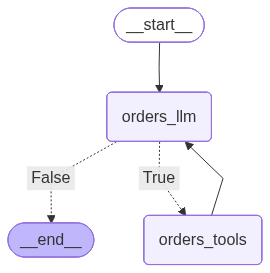

In [ ]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from IPython.display import Image
import json

#An Agent State class that keep state of the agent while it answers a query
class OrdersAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

#-----------------------------------------------------------------------------
#An agent class that manages all agentic interactions
class OrdersAgent:

    #Setup the agent graph, tools and memory
    def __init__(self, model, tools, system_prompt, debug):

        self.system_prompt=system_prompt
        self.debug=debug

        #Setup the graph for the agent manually
        agent_graph=StateGraph(OrdersAgentState)
        agent_graph.add_node("orders_llm",self.call_llm)
        agent_graph.add_node("orders_tools",self.call_tools)
        agent_graph.add_conditional_edges(
            "orders_llm",
            self.is_tool_call,
            {True: "orders_tools", False: END }
        )
        agent_graph.add_edge("orders_tools","orders_llm")
        #Set where there graph starts
        agent_graph.set_entry_point("orders_llm")

        #Add chat memory
        self.memory=MemorySaver()
        #compile the graph
        self.agent_graph = agent_graph.compile(checkpointer=self.memory)

        #Setup tools
        self.tools = { tool.name : tool for tool in tools }
        if self.debug:
            print("\nTools loaded :", self.tools)

        #attach tools to model
        self.model=model.bind_tools(tools)


    #Call the LLM with the messages to get next action/result
    def call_llm(self, state:OrdersAgentState):

        messages=state["messages"]

        #If system prompt exists, add to messages in the front
        if self.system_prompt:
            messages = [SystemMessage(content=self.system_prompt)] + messages

        #invoke the model with the message history
        result = self.model.invoke(messages)
        if self.debug:
            print(f"\nLLM Returned : {result}")
        #Return the LLM output
        return { "messages":[result] }


    #Check if the next action is a tool call.
    def is_tool_call(self, state:OrdersAgentState):
        last_message = state["messages"][-1]
        #print("Last result from LLM : ", last_message)
        #If tool action is requested
        if len(last_message.tool_calls) > 0 :
            return True
        else:
            return False

    #Execute the tool requested with the given parameters
    def call_tools(self, state:OrdersAgentState):
        #Get last message
        tool_calls = state["messages"][-1].tool_calls
        results=[]

        #Multiple tool calls may be requested. Execute one by one
        for tool in tool_calls:
            #Handle tool missing error
            if not tool["name"] in self.tools:
                print(f"Unknown tool name {tool}")
                result = "Invalid tool found. Please retry"
            else:
                #Call the tool and collect results
                result=self.tools[tool["name"]].invoke(tool["args"])

            #append results to the list of tool results
            results.append(ToolMessage(tool_call_id=tool['id'],
                                       name=tool['name'],
                                       content=str(result)))

            if self.debug:
                print(f"\nTools returned {results}")
            #return tool results
            return { "messages" : results }

#-----------------------------------------------------------------------------
#Setup the custom agent

#Note that this is a string, since the model init only accepts a string.
system_prompt = """
    You are professional chatbot that manages orders for headphone sold by our company.
    The tools allow for retrieving order details as well as update order quantity.
    Do NOT reveal information about other orders than the one requested.
    You will handle small talk and greetings by producing professional responses.
    """

#Create the custom orders agent
orders_agent = OrdersAgent(model,
                           [get_order_details, update_quantity],
                           system_prompt,
                           debug=False)

#Visualize the Agent
Image(orders_agent.agent_graph.get_graph().draw_mermaid_png())

In [ ]:
import uuid
#Send a sequence of messages to chatbot and get its response
#This simulates the conversation between the user and the Agentic chatbot
user_inputs = [
    "How are you doing?",
    "Please show me the details of the order ORD-3159",
    "Can you add one more of that headphone to the order? ",
    "Can you show me the details again ? ",
    "What about order ORD-5092 ?",
    "Bye"
]

#Create a new thread
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = orders_agent.agent_graph.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")

----------------------------------------
USER : How are you doing?

AGENT : I'm here and ready to assist you with your headphone order inquiries! How can I help you today?
----------------------------------------
USER : Please show me the details of the order ORD-3159

AGENT : Here are the details for your order (ORD-3159):

- **Product Ordered:** Apple AirPods Max
- **Quantity Ordered:** 1
- **Delivery Date:** October 21, 2024

If you need any further assistance, feel free to ask!
----------------------------------------
USER : Can you add one more of that headphone to the order? 

AGENT : The quantity for your order (ORD-3159) has been successfully updated to 2 Apple AirPods Max. If there's anything else you need, just let me know!
----------------------------------------
USER : Can you show me the details again ? 

AGENT : Here are the updated details for your order (ORD-3159):

- **Product Ordered:** Apple AirPods Max
- **Quantity Ordered:** 2
- **Delivery Date:** October 21, 2024


# Routing

In [ ]:
import functools
# Helper function to invoke an agent
def agent_node(state, agent, name, config):

    #extract thread-id from request for conversation memory
    thread_id=config["metadata"]["thread_id"]
    #Set the config for calling the agent
    agent_config = {"configurable": {"thread_id": thread_id}}

    #Pass the thread-id to establish memory for chatbot
    #Invoke the agent with the state
    result = agent.invoke(state, agent_config)

    # Convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        final_result=AIMessage(result['messages'][-1].content)
    return {
        "messages": [final_result]
    }

#Create the product QnA node
product_QnA_node=functools.partial(agent_node,
                                   agent=product_QnA_agent,
                                   name="Product_QnA_Agent")
#Create the Orders node
#For a custom agent, the agent graph need to be provided as input
orders_node=functools.partial(agent_node,
                              agent=orders_agent.agent_graph,
                              name="Orders_Agent")

In [ ]:
#Creating the routing agent

from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
import operator

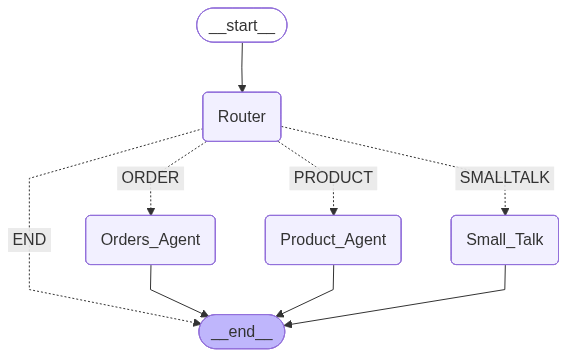

In [ ]:
#Create the chatbot
from IPython.display import Image

#Setup the system problem
system_prompt = """
You are a Router, that analyzes the input query and chooses 4 options:
SMALLTALK: If the user input is small talk, like greetings and good byes.
PRODUCT: If the query is a product question about headphone, like features, specifications and pricing.
ORDER: If the query is about orders for headphone, like order status, order details or update order quantity
END: Default, when its neither PRODUCT or ORDER.

The output should only be just one word out of the possible 4 : SMALLTALK, PRODUCT, ORDER, END.
"""

smalltalk_prompt="""
If the user request is small talk, like greetings and goodbyes, respond professionally.
Mention that you will be able to answer questions about headphone product features and provide order status and updates.
"""
class RouterAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class RouterAgent:

    def __init__(self, model, system_prompt, smalltalk_prompt, debug=False):

        self.system_prompt=system_prompt
        self.smalltalk_prompt=smalltalk_prompt
        self.model=model
        self.debug=debug

        router_graph=StateGraph(RouterAgentState)
        router_graph.add_node("Router",self.call_llm)
        router_graph.add_node("Product_Agent",product_QnA_node)
        router_graph.add_node("Orders_Agent",orders_node)
        router_graph.add_node("Small_Talk", self.respond_smalltalk)

        router_graph.add_conditional_edges(
            "Router",
            self.find_route,
            {"PRODUCT": "Product_Agent",
             "ORDER" : "Orders_Agent",
             "SMALLTALK" : "Small_Talk",
             "END": END }
        )

 #One way routing, not coming back to router
        router_graph.add_edge("Product_Agent",END)
        router_graph.add_edge("Orders_Agent",END)
        router_graph.add_edge("Small_Talk",END)

        #Set where there graph starts
        router_graph.set_entry_point("Router")
        self.router_graph = router_graph.compile()

    def call_llm(self, state:RouterAgentState):
        messages=state["messages"]
        if self.debug:
            print(f"Call LLM received {messages}")

        #If system prompt exists, add to messages in the front
        if self.system_prompt:
            messages = [SystemMessage(content=self.system_prompt)] + messages

        #invoke the model with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"Call LLM result {result}")
        return { "messages":[result] }

    def respond_smalltalk(self, state:RouterAgentState):
        messages=state["messages"]
        if self.debug:
            print(f"Small talk received: {messages}")

        #If system prompt exists, add to messages in the front

        messages = [SystemMessage(content=self.smalltalk_prompt)] + messages

        #invoke the model with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"Small talk result {result}")
        return { "messages":[result] }

    def find_route(self, state:RouterAgentState):
        last_message = state["messages"][-1]
        if self.debug:
            print("Router: Last result from LLM : ", last_message)

        #Set the last message as the destination
        destination=last_message.content

        if self.debug:
            print(f"Destination chosen : {destination}")
        return destination


router_agent = RouterAgent(model,
                           system_prompt,
                           smalltalk_prompt,
                           debug=False)

Image(router_agent.router_graph.get_graph().draw_mermaid_png())

In [ ]:
#Execute a single request
messages=[HumanMessage(content="Tell me about the features of JBL Tour One M2")]
result=router_agent.router_graph.invoke({"messages":messages},config)
for message in result['messages']:
    print(message.pretty_repr())

================================ Human Message =================================

Tell me about the features of JBL Tour One M2
================================== Ai Message ==================================

PRODUCT
================================== Ai Message ==================================

The JBL Tour One M2 features include:

- **Studio-quality sound**: Delivers high-fidelity audio for an immersive listening experience.
- **Adaptive Active Noise Cancellation (ANC)**: Automatically adjusts to your environment to block out unwanted noise.
- **Customizable EQ**: Allows you to tailor the sound profile to your preferences through the JBL app.
- **50-hour playback time**: Offers extended listening without the need for frequent recharging.
- **Lightweight construction**: Designed for comfort, making it suitable for commuters and music enthusiasts who prioritize both performance and portability.


In [ ]:
#Execute a single request
messages=[HumanMessage(content="What is the status of order ORD-2047?")]
result=router_agent.router_graph.invoke({"messages":messages},config)
for message in result['messages']:
    print(message.pretty_repr())

================================ Human Message =================================

What is the status of order ORD-2047?
================================== Ai Message ==================================

ORDER
================================== Ai Message ==================================

Here are the details for order (ORD-2047):

- **Product Ordered:** Bose QuietComfort Ultra
- **Quantity Ordered:** 2
- **Delivery Date:** October 20, 2024

If you have any more questions or need further assistance, feel free to ask!


In [52]:
import uuid
#Send a sequence of messages to chatbot and get its response
#This simulates the conversation between the user and the Agentic chatbot
user_inputs = [
    "How are you doing?",
    "Please show me the details of the order ORD-4278 ",
    "Can you add one more of that headphone to the order? ",
    "Tell me about the features of Sony WH-1000XM5 headphone",
    "How much does it cost?",
    "Bye"
]

#Create a new thread
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = router_agent.router_graph.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")

----------------------------------------
USER : How are you doing?

AGENT : I'm doing well, thank you! How about you? If you have any questions about headphone product features or need updates on your order status, feel free to ask!
----------------------------------------
USER : Please show me the details of the order ORD-4278 

AGENT : Here are the details for your order:

- **Order ID**: ORD-4278
- **Product Ordered**: Sennheiser Momentum 4
- **Quantity Ordered**: 5
- **Delivery Date**: October 24, 2024

If you need any further assistance, feel free to ask!
----------------------------------------
USER : Can you add one more of that headphone to the order? 

AGENT : I have successfully updated your order. The quantity of the Sennheiser Momentum 4 headphones has been increased to 6. If you need any further assistance, just let me know!
----------------------------------------
USER : Tell me about the features of Sony WH-1000XM5 headphone

AGENT : The Sony WH-1000XM5 headphones come w